In [3]:
import os
import sys
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')
pplt.rc.update({'figure.dpi':100})

In [4]:
with open('../scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['experiments']
SPLIT      = 'valid'   

In [5]:
def get_r2(ytrue,ypred):
    dims  = list(ytrue.dims)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [6]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = []

for name,run in MODELS['pod']['runs'].items():
    filepath  = os.path.join(PREDSDIR,f'{name}_{SPLIT}_pr.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath) as ds:
        ypred = ds.pr.load()
    ytrue,ypred = xr.align(truepr,ypred,join='inner')
    r2     = get_r2(ytrue,ypred)
    r2mean = float(r2) if ('seed' not in r2.dims) else float(r2.mean('seed'))
    r2std  = 0.0 if ('seed' not in r2.dims) else float(r2.std('seed'))
    color  = 'gray6'
    results.append((name,r2mean,r2std,color))

for name,run in MODELS['nn']['runs'].items():
    filepath = os.path.join(PREDSDIR,f'{name}_{SPLIT}_predictions.nc')
    if not os.path.exists(filepath):
        filepath = os.path.join(PREDSDIR,f'{name}_{SPLIT}_pr.nc')
    if not os.path.exists(filepath):
        matches = sorted(glob.glob(os.path.join(PREDSDIR,f'*{name}*{SPLIT}*.nc')))
        if len(matches) == 0:
            continue
        filepath = matches[0]
    with xr.open_dataset(filepath) as ds:
        ypred = ds.pr.load()
    ytrue,ypred = xr.align(truepr,ypred,join='inner')
    r2     = get_r2(ytrue,ypred)
    r2mean = float(r2) if ('seed' not in r2.dims) else float(r2.mean('seed'))
    r2std  = 0.0 if ('seed' not in r2.dims) else float(r2.std('seed'))
    kind   = run.get('kind','baseline')
    color  = ('yellow4' if (kind=='nonparametric') else 'red4' if (kind=='parametric') else 'blue4')
    results.append((name,r2mean,r2std,color))

for name,run in MODELS['sr']['runs'].items():
    filepath = os.path.join(PREDSDIR,f'{name}_{SPLIT}_predictions.nc')
    if not os.path.exists(filepath):
        filepath = os.path.join(PREDSDIR,f'{name}_{SPLIT}_pr.nc')
    if not os.path.exists(filepath):
        matches = sorted(glob.glob(os.path.join(PREDSDIR,f'*{name}*{SPLIT}*.nc')))
        if len(matches) == 0:
            continue
        filepath = matches[0]
    with xr.open_dataset(filepath) as ds:
        ypred = ds.pr.load()
    ytrue,ypred = xr.align(truepr,ypred,join='inner')
    r2     = get_r2(ytrue,ypred)
    r2mean = float(r2) if ('seed' not in r2.dims) else float(r2.mean('seed'))
    r2std  = 0.0 if ('seed' not in r2.dims) else float(r2.std('seed'))
    color  = 'violet4'
    results.append((name,r2mean,r2std,color))

print(f'Found {len(results)} models with predictions!')

Found 2 models with predictions!


In [7]:
results.sort(key=lambda x:x[2])
labels = [item[0] for item in results]
means  = [item[1] for item in results]
stds   = [item[2] for item in results]
colors = [item[3] for item in results]

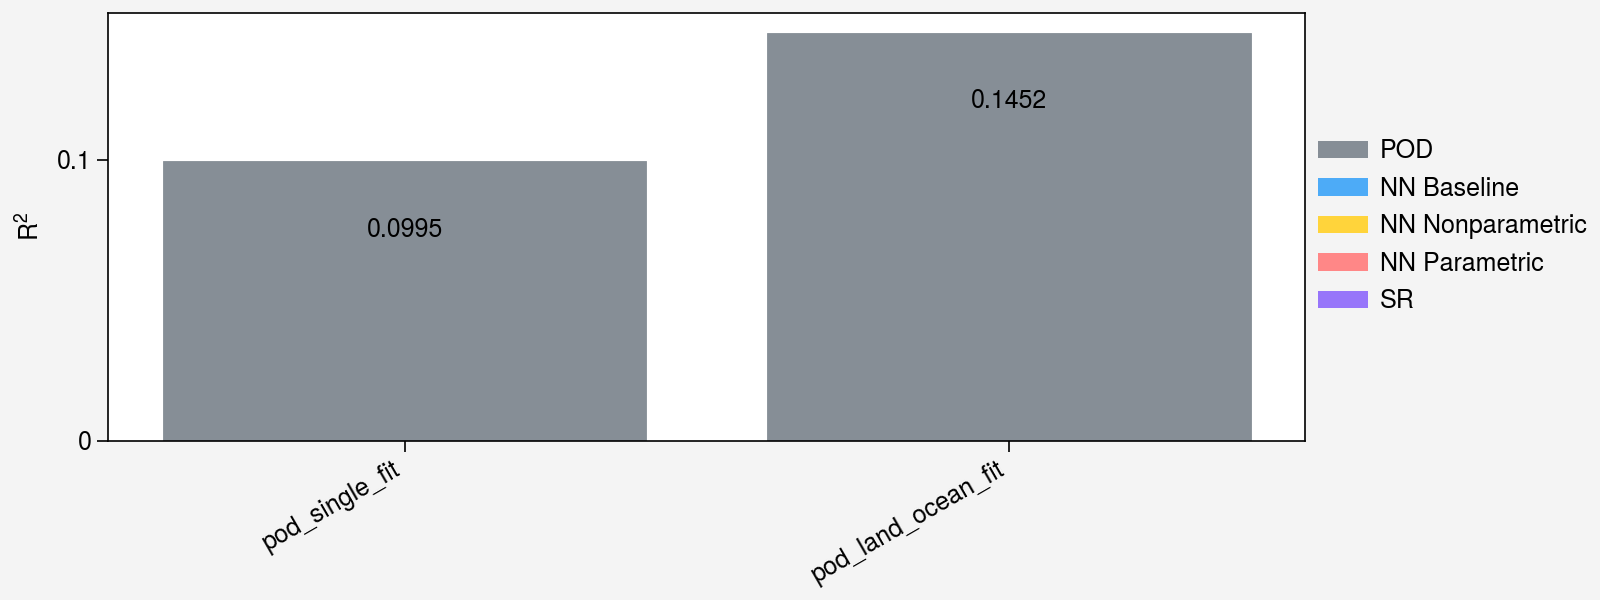

In [8]:
fig,ax = pplt.subplots(width=8,height=3)
ax.format(grid=False,xrotation=30,ylabel='R$^2$',yticks=0.1,yminorticks='none')
bars = ax.bar(labels,means,color=colors)
for bar,mean,std in zip(bars,means,stds):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height()-0.02,f'{mean:.4f}',ha='center',va='top')
elements = [Patch(facecolor='gray6',label='POD'),
            Patch(facecolor='blue4',label='NN Baseline'),
            Patch(facecolor='yellow4',label='NN Nonparametric'),
            Patch(facecolor='red4',label='NN Parametric'),
            Patch(facecolor='violet4',label='SR')]
ax.legend(handles=elements,loc='r',ncols=1,frameon=False)
pplt.show()